# Dynamic Ensembles: Comparing Several Approaches

This notebook explores how to combine nixtla's neuralforecast models using several ensemble approaches.
1. Loading M3's monthly dataset
2. Preparing and running cross-validation with 7 neural networks
3. Fitting several combination rules using out-of-sample data from cross-validation
4. Getting forecasts and combining them
5. Evaluating all models

In [1]:
import warnings

warnings.filterwarnings("ignore")

If necessary, install the package using pip:

In [2]:
# !pip install metaforecast=='0.1.3'

### 1. Data preparation

Let's start by loading the dataset.
This tutorial uses the M3 monthly dataset available on datasetsforecast.

We also set the forecasting horizon and input size (number of lags) to 12.

In [3]:
import pandas as pd

from datasetsforecast.m3 import M3

horizon = 12
n_lags = 12

df, *_ = M3.load('.',group='Monthly')

Split the dataset into training and testing sets:

In [4]:
df_by_unq = df.groupby('unique_id')

train_l, test_l = [], []
for g, df_ in df_by_unq:
    df_ = df_.sort_values('ds')

    train_df_g = df_.head(-horizon)
    test_df_g = df_.tail(horizon)

    train_l.append(train_df_g)
    test_l.append(test_df_g)

train_df = pd.concat(train_l).reset_index(drop=True)
test_df = pd.concat(test_l).reset_index(drop=True)

train_df.query('unique_id=="M1000"').tail()

,unique_id,ds,y
286,M1000,1992-10-31,4563.4
287,M1000,1992-11-30,4551.8
288,M1000,1992-12-31,4577.4
289,M1000,1993-01-31,4592.4
290,M1000,1993-02-28,4632.2


In [5]:
test_df.query('unique_id=="M1000"').head()

,unique_id,ds,y
36,M1000,1993-03-31,4625.6
37,M1000,1993-04-30,4668.2
38,M1000,1993-05-31,4598.0
39,M1000,1993-06-30,4619.4
40,M1000,1993-07-31,4640.4


### 2. Model setup and cross-validation

Let's start by setting up the ensemble members: 7 neural networks based on neuralforecast.

We carry out a cross-validation procedure to get out-of-sample forecasts that will be used to fit the combination rule

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import (NHITS,
                                   LSTM,
                                   GRU,
                                   NBEATS,
                                   MLP,
                                   TiDE)

CONFIG = {
    'input_size': n_lags,
    'h': horizon,
    'accelerator': 'cpu', 
    'max_steps':1000,
}

models = [
    NBEATS(**CONFIG, stack_types=3*["identity"]),
    NHITS(**CONFIG),
    MLP( **CONFIG),
    MLP(num_layers=3, **CONFIG),
    LSTM(**CONFIG),
    GRU(**CONFIG),
    TiDE( **CONFIG),
]


nf = NeuralForecast(models=models, freq='M')

In [ ]:
%%capture

# should try nf.predict_insample
n_windows = train_df['unique_id'].value_counts().min() - n_lags - horizon
n_windows = int(n_windows // 2)

fcst_cv = nf.cross_validation(df=train_df, n_windows=n_windows, step_size=1)
fcst_cv = fcst_cv.reset_index()
fcst_cv = fcst_cv.groupby(['unique_id', 'cutoff']).head(1).drop(columns='cutoff')

In [8]:
fcst_cv.head()

,unique_id,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,y
0,M1,1992-07-31,4270.607422,4316.121094,3988.292969,4269.679199,3331.872803,3312.583252,4209.511719,5880.0
12,M1,1992-08-31,5383.976562,5088.954102,4664.032227,4608.907227,3408.262695,3532.260254,4589.873047,1680.0
24,M1,1992-09-30,3962.103271,3926.756348,3292.554443,3432.223633,3158.096924,3155.144531,6003.843750,6720.0
36,M1,1992-10-31,3850.518799,3936.579346,4416.983398,4314.682617,2995.153809,3089.166016,4937.783691,2040.0
48,M1,1992-11-30,4311.153320,4394.302734,3661.406250,3534.437988,3103.114746,3088.328125,3061.584473,6480.0


### 3. Ensemble combination rule

In this example, we'll compare several dynamic ensembles

In [9]:
from metaforecast.ensembles import (MLpol, MLewa, ADE, LossOnTrain, BestOnTrain, EqAverage, Windowing)

In [10]:
TRIM_R = 0.8

combiners = {
    'ADE': ADE(freq='M', meta_lags=list(range(1, 4)), trim_ratio=TRIM_R, trim_by_uid=False),
    'MLpol': MLpol(loss_type='square', gradient=True, trim_ratio=TRIM_R, weight_by_uid=False),
    'MLewa': MLewa(loss_type='square', gradient=True, trim_ratio=TRIM_R, weight_by_uid=False),
    'LossOnTrain': LossOnTrain(trim_ratio=TRIM_R, weight_by_uid=False),
    'BestOnTrain': BestOnTrain(select_by_uid=False),
    'EqAverage': EqAverage(select_by_uid=False, trim_ratio=TRIM_R),
    'Windowing': Windowing(freq='M', trim_ratio=TRIM_R, select_best=False, weight_by_uid=False),
    'BLAST': Windowing(freq='M', trim_ratio=TRIM_R, select_best=True, weight_by_uid=False),
}

In [11]:
for k in combiners:
    print(f'Fitting {k}')
    combiners[k].fit(fcst_cv)

Fitting ADE
Fitting MLpol
Fitting MLewa
Fitting LossOnTrain
Fitting BestOnTrain
Fitting EqAverage
Fitting Windowing
Fitting BLAST


Let's look at the weights of different combiners

<Axes: >

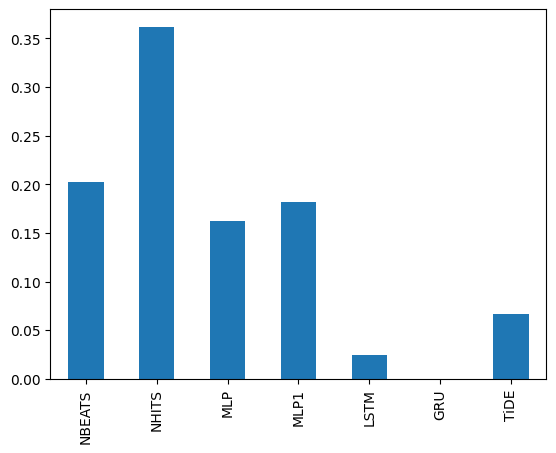

In [12]:
combiners['MLpol'].uid_coefficient['M1000'].plot.bar()

<Axes: >

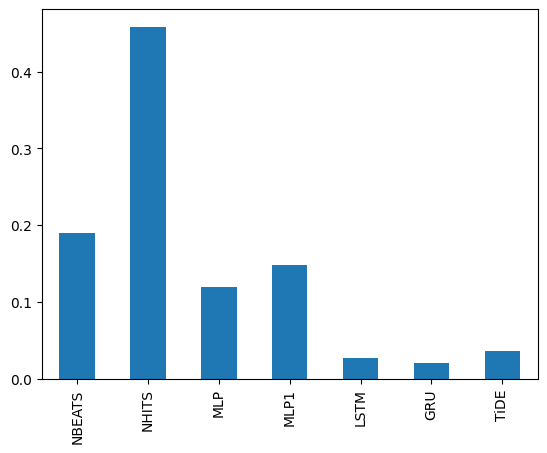

In [13]:
combiners['MLewa'].uid_coefficient['M1000'].plot.bar()

<Axes: >

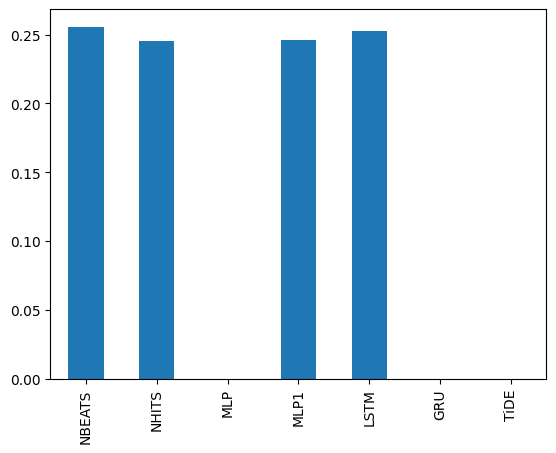

In [14]:
combiners['Windowing'].weights.loc['M1000',:].plot.bar()

Then, we refit the neural networks are get the test forecasts

In [ ]:
%%capture

nf.fit(df=train_df)

In [ ]:
%%capture

fcst = nf.predict(step_size=1)

In [17]:
fcst.query('unique_id=="M1"')

,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE
unique_id,,,,,,,,
M1,1994-09-30,2820.708008,2837.058838,2383.298828,2454.077393,2507.238525,2390.672607,2070.891602
M1,1994-10-31,2353.479248,2515.124512,2158.801270,2129.693848,2583.255859,2305.683838,2451.634033
M1,1994-11-30,2303.218750,2391.572754,2291.510254,2139.453857,2939.735107,2787.014160,1721.748047
M1,1994-12-31,2779.379883,2526.065918,2591.097412,2590.750244,2814.711182,2776.601318,2240.189941
M1,1995-01-31,2188.668457,2063.863525,2234.466553,1887.351929,2838.986328,2785.913818,1796.146118
M1,1995-02-28,1911.853271,2175.461670,1985.965088,1816.956787,2691.198242,2710.279541,2631.498779
M1,1995-03-31,2451.522461,2249.096436,2160.844971,1911.716309,2619.605469,2653.789551,1920.423096
M1,1995-04-30,1735.337402,1839.155762,1614.420044,1335.228027,2504.666992,2538.148926,2000.088135
M1,1995-05-31,1939.377686,2237.283691,2295.252930,2200.254150,2474.093994,2538.217285,3073.768555


In [18]:
ensemble_fcst = {}
for k in combiners:
    print(k)
    if k == 'ADE':
        # need to make sure unique_id is in columns
        fc = combiners[k].predict(fcst.reset_index(), train=train_df, h=horizon)
    else:
        fc = combiners[k].predict(fcst.reset_index())

    ensemble_fcst[k] = fc

ensemble_fcst_df = pd.DataFrame(ensemble_fcst)

ADE
MLpol
MLewa
LossOnTrain
BestOnTrain
EqAverage
Windowing
BLAST


In [19]:
ensemble_fcst_df

,ADE,MLpol,MLewa,LossOnTrain,BestOnTrain,EqAverage,Windowing,BLAST
0,2734.990919,2633.876117,2687.956142,2647.597933,2820.708008,2600.476318,2609.517685,2820.708008
1,2413.129298,2346.027112,2375.503276,2416.961861,2353.479248,2348.070947,2372.301306,2353.479248
2,2368.810476,2263.482370,2296.720479,2512.772930,2303.218750,2413.098145,2457.888033,2303.218750
3,2615.789141,2581.755320,2583.917473,2726.531104,2779.379883,2660.400928,2688.874069,2779.379883
4,2119.322474,2066.855810,2072.368257,2353.839662,2188.668457,2242.667358,2297.588398,2188.668457
...,...,...,...,...,...,...,...,...
17131,5235.239195,5263.440157,5260.213604,5228.020998,5255.608398,5242.863867,5228.022853,5255.608398
17132,5236.594895,5274.892725,5272.110740,5228.778586,5260.446777,5251.575293,5228.879529,5260.446777
17133,5233.346570,5275.373552,5271.142153,5224.094460,5230.098633,5253.171680,5223.840454,5230.098633
17134,5247.344425,5305.818907,5300.775081,5238.732074,5271.788086,5278.508789,5238.902449,5271.788086


In [20]:
fcst_all = pd.concat([fcst.reset_index(),ensemble_fcst_df],axis=1)

fcst_all.head()

,unique_id,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,ADE,MLpol,MLewa,LossOnTrain,BestOnTrain,EqAverage,Windowing,BLAST
0,M1,1994-09-30,2820.708008,2837.058838,2383.298828,2454.077393,2507.238525,2390.672607,2070.891602,2734.990919,2633.876117,2687.956142,2647.597933,2820.708008,2600.476318,2609.517685,2820.708008
1,M1,1994-10-31,2353.479248,2515.124512,2158.801270,2129.693848,2583.255859,2305.683838,2451.634033,2413.129298,2346.027112,2375.503276,2416.961861,2353.479248,2348.070947,2372.301306,2353.479248
2,M1,1994-11-30,2303.218750,2391.572754,2291.510254,2139.453857,2939.735107,2787.014160,1721.748047,2368.810476,2263.482370,2296.720479,2512.772930,2303.218750,2413.098145,2457.888033,2303.218750
3,M1,1994-12-31,2779.379883,2526.065918,2591.097412,2590.750244,2814.711182,2776.601318,2240.189941,2615.789141,2581.755320,2583.917473,2726.531104,2779.379883,2660.400928,2688.874069,2779.379883
4,M1,1995-01-31,2188.668457,2063.863525,2234.466553,1887.351929,2838.986328,2785.913818,1796.146118,2119.322474,2066.855810,2072.368257,2353.839662,2188.668457,2242.667358,2297.588398,2188.668457


### 4. Evaluation

Finally, we compare all approaches

In [21]:
test_df = test_df.merge(fcst_all, on=['unique_id','ds'], how="left")

In [22]:
from neuralforecast.losses.numpy import smape
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(test_df, [smape], agg_by=['unique_id'])
evaluation_df

,metric,unique_id,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,ADE,MLpol,MLewa,LossOnTrain,BestOnTrain,EqAverage,Windowing,BLAST
0,smape,M1,0.557906,0.565255,0.534834,0.545832,0.581718,0.577866,0.542147,0.553334,0.548903,0.550354,0.555674,0.557906,0.550354,0.551796,0.557906
1,smape,M10,0.203316,0.192507,0.188595,0.183235,0.187489,0.188297,0.199679,0.192563,0.192023,0.192340,0.187226,0.203316,0.189806,0.186955,2.000000
2,smape,M100,0.092943,0.084622,0.090799,0.095776,0.118231,0.119362,0.115861,0.098916,0.091347,0.089711,0.090521,0.092943,0.096197,0.090546,0.092943
3,smape,M1000,0.011336,0.011435,0.013824,0.010244,0.010340,0.004813,0.006411,0.006530,0.010227,0.010599,0.006014,0.011336,0.007341,0.006490,0.011336
4,smape,M1001,0.019537,0.019699,0.024808,0.019278,0.015281,0.007963,0.011028,0.013953,0.018969,0.019145,0.014497,0.019537,0.015982,0.014861,0.019537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,smape,M995,0.007859,0.005549,0.012240,0.006474,0.026410,0.007585,0.010029,0.007985,0.004580,0.004588,0.008676,0.007859,0.006321,0.009893,0.007859
1424,smape,M996,0.022319,0.022942,0.029199,0.026535,0.009965,0.007247,0.018761,0.017294,0.024090,0.023890,0.017470,0.022319,0.019209,0.017903,0.022319
1425,smape,M997,0.081531,0.080787,0.077392,0.075628,0.065652,0.060192,0.080346,0.075875,0.079193,0.079543,0.076511,0.081531,0.075707,0.076070,0.081531
1426,smape,M998,0.008090,0.007945,0.010729,0.010613,0.026844,0.018760,0.022788,0.012541,0.008733,0.008367,0.012279,0.008090,0.011400,0.012000,0.008090


In [23]:
evaluation_df.drop(columns=['metric','unique_id']).mean().sort_values()

MLewa          0.126739
MLpol          0.126860
Windowing      0.126917
LossOnTrain    0.127034
EqAverage      0.127254
NBEATS         0.127429
ADE            0.127547
NHITS          0.127779
MLP1           0.130285
MLP            0.130502
GRU            0.135435
TiDE           0.139523
LSTM           0.140415
BestOnTrain    0.183605
BLAST          0.188772
dtype: float64